# Desafío 1 - Análisis exploratorio de un dataset de precios de propiedades.

Objetivo: desarrollar un modelo de regresión que permita predecir el precio por metro cuadrado de una propiedad.

### Setup inicial

In [1]:
# initial setup
%run "common/0_notebooks_base_setup.py"

C:\Users\Lu\Lu\Digital House\grupo_6\DH_grupo_6common
default checking
Running command `conda list`... ok
jupyterlab=2.2.6 already installed
pandas=1.1.5 already installed
bokeh=2.2.3 already installed
seaborn=0.11.0 already installed
matplotlib=3.3.2 already installed
ipywidgets=7.5.1 already installed
pytest=6.2.1 already installed
chardet=4.0.0 already installed
psutil=5.7.2 already installed
scipy=1.5.2 already installed
statsmodels=0.12.1 already installed
scikit-learn=0.23.2 already installed
xlrd=2.0.1 already installed
Running command `conda install --yes nltk=3.5.0`... ok
Solving environment: ...working... done

# All requested packages already installed.


unidecode=1.1.1 already installed
pydotplus=2.0.2 already installed
pandas-datareader=0.9.0 already installed
flask=1.1.2 already installed


In [2]:
#importamos de todas las librerías que vamos a utilizar

import numpy as np
import pandas as pd
import re
import geopandas as gpd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import shapely 
import descartes 
import pyproj 
import unicodedata
import squarify
import pygal
from scipy.stats import iqr

In [3]:
%matplotlib inline

#Con esto establecemos el backend de matplotlib en el backend 'en línea', la salida de los comandos de trazado se muestra
#en línea dentro de las interfaces, directamente debajo de la celda de código que lo produjo

In [4]:
pd.options.display.float_format='{:,.2f}'.format

### Procesamiento de los datos


In [5]:
#Vamos a importar el dataset original, creando un Dataframe y luego, mostrar los primeros cinco registros para ver cómo se presenta la información:

data_location = "Data/properatti.csv"

original_data = pd.read_csv(data_location, sep=",", encoding="latin1")


In [6]:
#Mostramos el esquema y los primeros 5 registros del data set:

original_data.head(5)

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,"3,430,787.00","-34.6618237,-58.5088387",-34.66,...,40.00,"1,127.27","1,550.00",nan,nan,nan,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,"3,432,039.00","-34.9038831,-57.9643295",-34.90,...,nan,nan,nan,nan,nan,nan,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en dÃ©cimo piso al frent...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...
2,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,"3,430,787.00","-34.6522615,-58.5229825",-34.65,...,55.00,"1,309.09","1,309.09",nan,nan,nan,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...
3,3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,"3,431,333.00","-34.6477969,-58.5164244",-34.65,...,nan,nan,nan,nan,nan,nan,http://www.properati.com.ar/15boh_venta_ph_lin...,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,https://thumbs4.properati.com/3/DgIfX-85Mog5SP...
4,4,sell,apartment,Centro,|Argentina|Buenos Aires Costa AtlÃ¡ntica|Mar d...,Argentina,Buenos Aires Costa AtlÃ¡ntica,"3,435,548.00","-38.0026256,-57.5494468",-38.00,...,35.00,"1,828.57","1,828.57",nan,nan,nan,http://www.properati.com.ar/15bok_venta_depart...,DEPARTAMENTO CON FANTÃSTICA ILUMINACIÃN NATU...,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...,https://thumbs4.properati.com/5/xrRqlNcSI_vs-f...


Exploramos el data set, obteniendo un primer acercamiento de sus métricas:

In [7]:
print(original_data.shape)


(121220, 26)


In [8]:

original_data.describe()


,Unnamed: 0,geonames_id,lat,lon,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses
count,"121,220.00","102,503.00","69,670.00","69,670.00","100,810.00","100,810.00","100,810.00","81,892.00","101,313.00","68,617.00","87,658.00","7,899.00","47,390.00","14,262.00"
mean,"60,609.50","3,574,442.32",-34.63,-59.27,"468,525.93","4,229,396.83","239,700.58",233.80,133.05,"2,160.09","6,912.22",17.45,3.08,"5,009.23"
std,"34,993.34","354,130.62",1.98,2.30,"2,260,100.59","6,904,714.13","391,323.88","1,782.22",724.35,"2,759.29","28,378.64",120.24,1.86,"120,440.26"
min,0.00,"3,427,208.00",-54.82,-75.68,0.00,0.00,0.00,0.00,0.00,0.60,1.51,1.00,1.00,1.00
25%,"30,304.75","3,430,234.00",-34.67,-58.73,"110,000.00","1,583,309.44","89,733.88",50.00,45.00,"1,218.18","1,550.00",1.00,2.00,"1,000.00"
50%,"60,609.50","3,433,910.00",-34.60,-58.48,"185,000.00","2,558,452.50","145,000.00",84.00,75.00,"1,800.00","2,213.11",3.00,3.00,"2,000.00"
75%,"90,914.25","3,836,668.00",-34.44,-58.40,"420,000.00","4,675,792.50","265,000.00",200.00,150.00,"2,486.41","3,355.55",6.00,4.00,"4,000.00"
max,"121,219.00","6,948,895.00",4.55,-53.73,"650,000,000.00","821,271,104.30","46,545,445.00","200,000.00","187,000.00","206,333.33","3,999,999.96","3,150.00",32.00,"10,001,500.00"


In [9]:
#En resumen, estas son las columnas que presenta:
    
original_data.columns

Index(['Unnamed: 0', 'operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
       'rooms', 'expenses', 'properati_url', 'description', 'title',
       'image_thumbnail'],
      dtype='object')

Atento el datset contiene 121.220 registros, analizaremos si es posible descartar, en primer lugar, aquellos que pertenezcan a
provincias que no tengan un % representativo dentro del total.
Para esto, entendemos que es posible utilizar la columna 'state_name', que representaría la provincia/localidad principal de cada unidad.

Analizamos proporción de valores Nan del dataset

In [10]:
missing_values_sum = original_data.isnull().sum()

In [11]:
missing_values_percent = original_data.isnull().mean()*100

In [12]:
missing_values_percent

Unnamed: 0                    0.00
operation                     0.00
property_type                 0.00
place_name                    0.02
place_with_parent_names       0.00
country_name                  0.00
state_name                    0.00
geonames_id                  15.44
lat-lon                      42.53
lat                          42.53
lon                          42.53
price                        16.84
currency                     16.84
price_aprox_local_currency   16.84
price_aprox_usd              16.84
surface_total_in_m2          32.44
surface_covered_in_m2        16.42
price_usd_per_m2             43.39
price_per_m2                 27.69
floor                        93.48
rooms                        60.91
expenses                     88.23
properati_url                 0.00
description                   0.00
title                         0.00
image_thumbnail               2.57
dtype: float64

<AxesSubplot:>

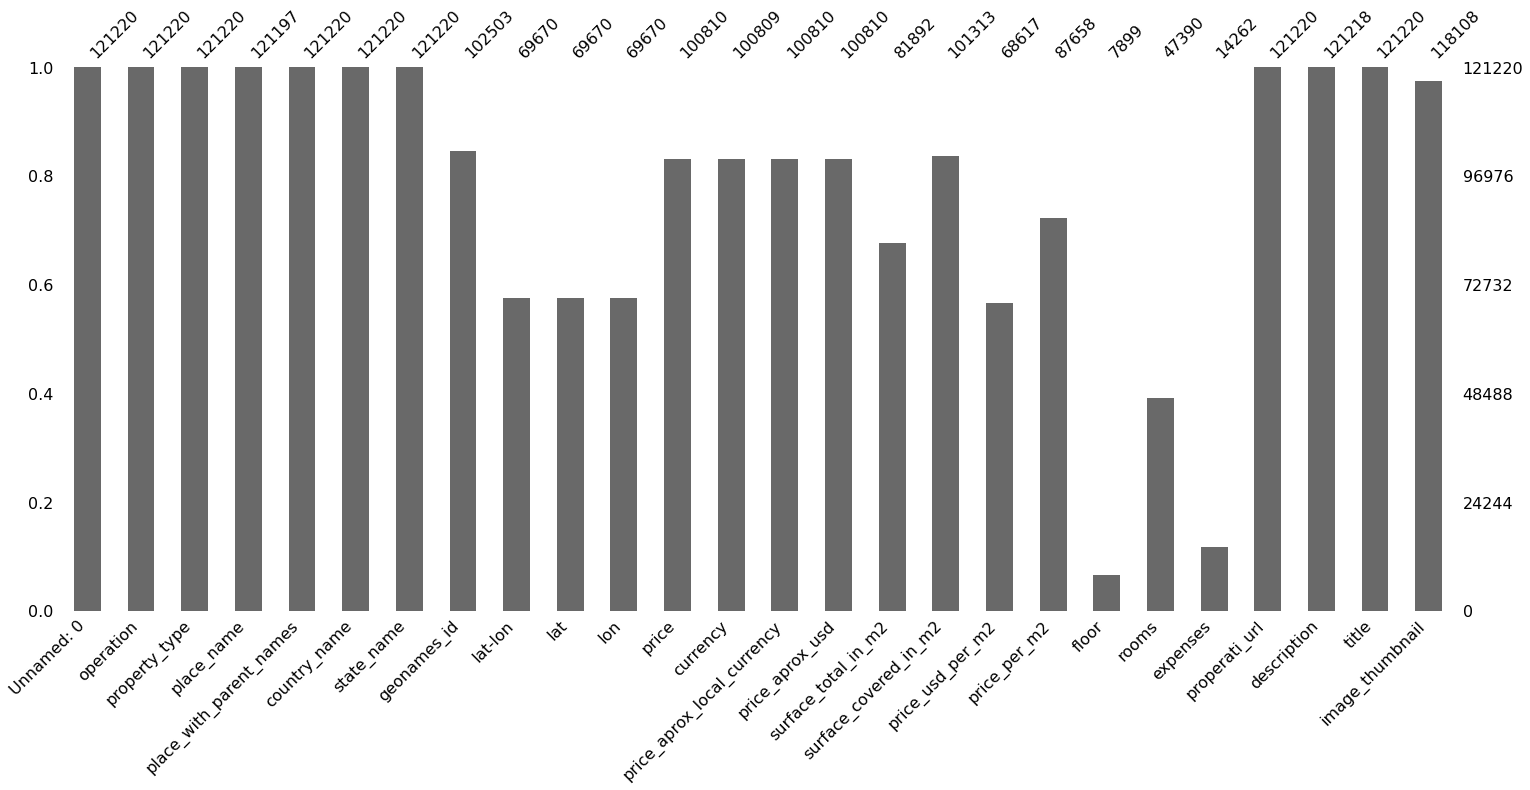

In [14]:
msno.bar(original_data)

<AxesSubplot:>

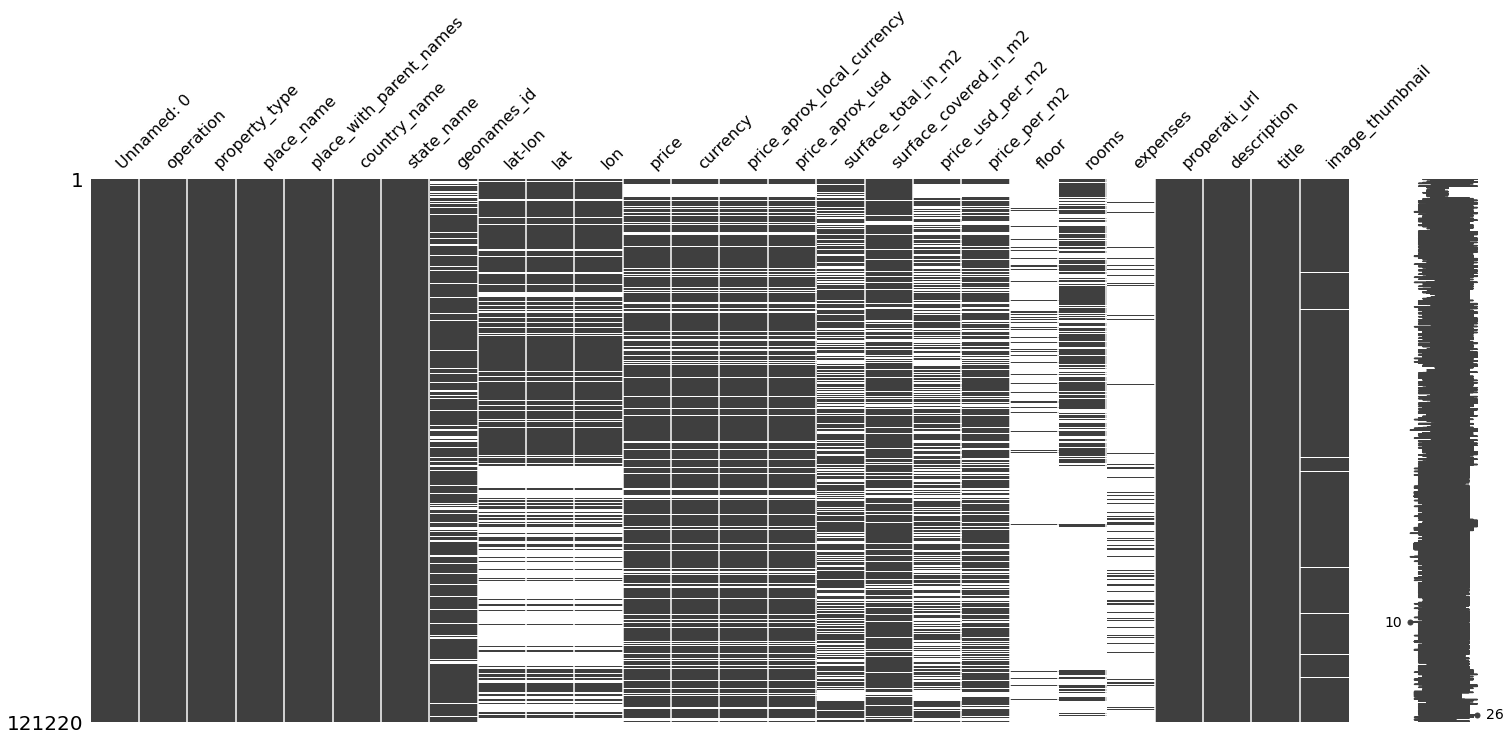

In [15]:
msno.matrix(original_data)

In [26]:
# msno.heatmap(original_data)

In [27]:
# msno.dendrogram(original_data)

<h3>Inicia la manipulación de datos</h3>

In [20]:
data_agrupado = original_data.groupby("state_name").size().reset_index(name="counts")
data_agrupado

,state_name,counts
0,Bs.As. G.B.A. Zona Norte,25560
1,Bs.As. G.B.A. Zona Oeste,9322
2,Bs.As. G.B.A. Zona Sur,13952
3,Buenos Aires Costa AtlÃ¡ntica,10006
4,Buenos Aires Interior,2291
5,Capital Federal,32316
6,Catamarca,27
7,Chaco,57
8,Chubut,259
9,Corrientes,583


In [13]:
#Verificaremos todos los valores DISTINTOS que tiene dicha columna y luego contaremos cuántos registros hay de cada uno (es decir, su frecuencia):

data_por_state = original_data["state_name"]

unique_states = set(data_por_state)
print("Estos son todos los valores únicos que contiene la columna state_name: " + str(unique_states))

#ACÁ HAY QUE PASAR ALGUNA FX O LIBRERIA QUE CORRIJA TILDES

Estos son todos los valores únicos que contiene la columna state_name: {'Salta', 'San Luis', 'TucumÃ¡n', 'RÃ\xado Negro', 'Misiones', 'Santa Fe', 'Entre RÃ\xados', 'Jujuy', 'CÃ³rdoba', 'San Juan', 'Catamarca', 'Chubut', 'Bs.As. G.B.A. Zona Sur', 'Bs.As. G.B.A. Zona Norte', 'Capital Federal', 'Santa Cruz', 'Tierra Del Fuego', 'Buenos Aires Costa AtlÃ¡ntica', 'Santiago Del Estero', 'NeuquÃ©n', 'Bs.As. G.B.A. Zona Oeste', 'Corrientes', 'Buenos Aires Interior', 'La Rioja', 'La Pampa', 'Chaco', 'Mendoza', 'Formosa'}


In [12]:
#Calculamos la frecuencia de cada provincia/estado

states_frequency = data_por_state.value_counts() 
print(states_frequency)
type(states_frequency)

Capital Federal                  32316
Bs.As. G.B.A. Zona Norte         25560
Bs.As. G.B.A. Zona Sur           13952
CÃ³rdoba                         12069
Santa Fe                         10172
Buenos Aires Costa AtlÃ¡ntica    10006
Bs.As. G.B.A. Zona Oeste          9322
Buenos Aires Interior             2291
RÃ­o Negro                         808
NeuquÃ©n                           733
Mendoza                            681
TucumÃ¡n                           674
Corrientes                         583
Misiones                           464
Entre RÃ­os                        369
Salta                              278
Chubut                             259
San Luis                           252
La Pampa                           157
Formosa                             65
Chaco                               57
San Juan                            40
Tierra Del Fuego                    31
Catamarca                           27
Jujuy                               26
Santa Cruz               

pandas.core.series.Series

In [102]:
#Calculamos la frecuencia en proporción al total:

proportions = data_por_state.value_counts(normalize=True)

print(100. * data_por_state.value_counts() / len(data_por_state))

Capital Federal                 26.66
Bs.As. G.B.A. Zona Norte        21.09
Bs.As. G.B.A. Zona Sur          11.51
CÃ³rdoba                         9.96
Santa Fe                         8.39
Buenos Aires Costa AtlÃ¡ntica    8.25
Bs.As. G.B.A. Zona Oeste         7.69
Buenos Aires Interior            1.89
RÃ­o Negro                       0.67
NeuquÃ©n                         0.60
Mendoza                          0.56
TucumÃ¡n                         0.56
Corrientes                       0.48
Misiones                         0.38
Entre RÃ­os                      0.30
Salta                            0.23
Chubut                           0.21
San Luis                         0.21
La Pampa                         0.13
Formosa                          0.05
Chaco                            0.05
San Juan                         0.03
Tierra Del Fuego                 0.03
Catamarca                        0.02
Jujuy                            0.02
Santa Cruz                       0.02
Santiago Del

In [29]:
#aca df es el original, si queremos el mapa con el limpio hay que cambiarlo!!
dg = original_data.loc[:, ['state_name', 'lat',"lon"]]
print (dg)


                           state_name    lat    lon
0                     Capital Federal -34.66 -58.51
1              Bs.As. G.B.A. Zona Sur -34.90 -57.96
2                     Capital Federal -34.65 -58.52
3                     Capital Federal -34.65 -58.52
4       Buenos Aires Costa AtlÃ¡ntica -38.00 -57.55
...                               ...    ...    ...
121215                Capital Federal    nan    nan
121216       Bs.As. G.B.A. Zona Norte    nan    nan
121217                Capital Federal -34.57 -58.48
121218  Buenos Aires Costa AtlÃ¡ntica    nan    nan
121219                Capital Federal    nan    nan

[121220 rows x 3 columns]


In [30]:
geodg = gpd.GeoDataFrame(dg, geometry=gpd.points_from_xy(dg.lon, dg.lat))
print (geodg)

                           state_name    lat    lon  \
0                     Capital Federal -34.66 -58.51   
1              Bs.As. G.B.A. Zona Sur -34.90 -57.96   
2                     Capital Federal -34.65 -58.52   
3                     Capital Federal -34.65 -58.52   
4       Buenos Aires Costa AtlÃ¡ntica -38.00 -57.55   
...                               ...    ...    ...   
121215                Capital Federal    nan    nan   
121216       Bs.As. G.B.A. Zona Norte    nan    nan   
121217                Capital Federal -34.57 -58.48   
121218  Buenos Aires Costa AtlÃ¡ntica    nan    nan   
121219                Capital Federal    nan    nan   

                           geometry  
0       POINT (-58.50884 -34.66182)  
1       POINT (-57.96433 -34.90388)  
2       POINT (-58.52298 -34.65226)  
3       POINT (-58.51642 -34.64780)  
4       POINT (-57.54945 -38.00263)  
...                             ...  
121215              POINT (nan nan)  
121216              POINT (nan nan)

In [31]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
geoarg = world[world.name=='Argentina']
print (geoarg)

    pop_est      continent       name iso_a3  gdp_md_est  \
9  44293293  South America  Argentina    ARG  879,400.00   

                                            geometry  
9  MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...  


In [32]:
def graficar(p_ciudad, p_pais):
    
    ax = p_pais.plot(figsize=(9,12), color='white', edgecolor='black')

    p_ciudad.plot(ax=ax, color='black', alpha= 0.4)

plt.show()


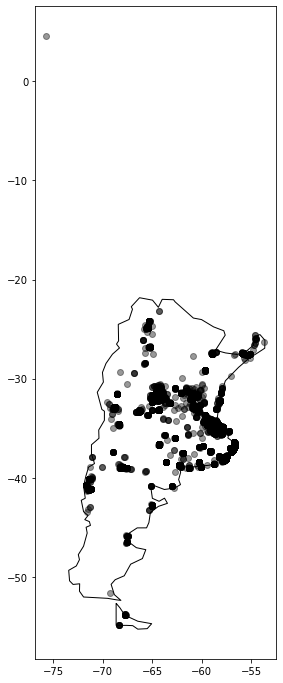

In [33]:
graficar (geodg, geoarg)

Teniendo en cuenta los resultado obtenidos, hemos decidido conservar únicamente aquellas provincias o estados que representen más del 0.02-
Es decir que eliminaremos aquellos registros que no correspondan a Capital Federal, GBA, Córdoba o Santa Fe.

In [106]:
#Armaremos un nuevo dataset, aplicando el filtro recientemente descrito:

freq_mask = proportions > 0.01
final_states = proportions[freq_mask]

states_list = list(final_states.index)

In [107]:
states_list
print(states_list)

['Capital Federal', 'Bs.As. G.B.A. Zona Norte', 'Bs.As. G.B.A. Zona Sur', 'CÃ³rdoba', 'Santa Fe', 'Buenos Aires Costa AtlÃ¡ntica', 'Bs.As. G.B.A. Zona Oeste', 'Buenos Aires Interior']


In [120]:
mask_1 = original_data["state_name"] == 'Capital Federal'
mask_2 = original_data["state_name"] == 'Bs.As. G.B.A. Zona Norte'
mask_3 = original_data["state_name"] == 'Bs.As. G.B.A. Zona Sur'
mask_4 = original_data["state_name"] == 'Córdoba'
mask_5 = original_data["state_name"] == 'Santa Fe'
mask_6 = original_data["state_name"] == 'Buenos Aires Costa Atlántica'
mask_7 = original_data["state_name"] == 'Bs.As. G.B.A. Zona Oeste'
mask_8 = original_data["state_name"] == 'Buenos Aires Interior'

state_mask = mask_1 | mask_2 | mask_3 | mask_4 | mask_5 | mask_6 | mask_7 | mask_8 

filtered_data = original_data[state_mask]
filtered_data.sample(5)

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
40692,40692,sell,house,Los Polvorines,|Argentina|Bs.As. G.B.A. Zona Norte|Malvinas A...,Argentina,Bs.As. G.B.A. Zona Norte,nan,"-34.515229,-58.709511",-34.52,...,70.00,nan,"1,685.71",nan,3.00,nan,http://www.properati.com.ar/18s0d_venta_casa_l...,Corredor Responsable: Mario Gabriel Gerez - CM...,VTA CASA EN BO.MARIANO MORENO-POLVORINES-MALV....,https://thumbs4.properati.com/2/3P_HkF1MnREmzs...
96859,96859,sell,apartment,Floresta,|Argentina|Capital Federal|Floresta|,Argentina,Capital Federal,"3,433,910.00","-34.629352033,-58.5048034193",-34.63,...,39.00,nan,nan,nan,nan,nan,http://www.properati.com.ar/1bj9s_venta_depart...,"Monoambiente en ""L"" amplio con vista al jardÃ­...",Departamento - Monte Castro,https://thumbs4.properati.com/5/KBRnjySAW6lkkJ...
6289,6289,sell,house,BelÃ©n de Escobar,|Argentina|Bs.As. G.B.A. Zona Norte|Escobar|Be...,Argentina,Bs.As. G.B.A. Zona Norte,"3,436,079.00",NaN,nan,...,233.00,366.88,"1,454.94",nan,nan,nan,http://www.properati.com.ar/15tgw_venta_casa_b...,Muy linda casa EN OBRA. Entrega aprox: Noviemb...,"Casa 924mÂ² con 2 Plantas, Escobar, BelÃ©n de ...",https://thumbs4.properati.com/7/OnNAB5zf7MlCs6...
30965,30965,sell,house,Tigre,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|,Argentina,Bs.As. G.B.A. Zona Norte,"3,427,753.00","-34.3835885983,-58.6811103738",-34.38,...,220.00,"1,484.38","1,727.27",nan,nan,nan,http://www.properati.com.ar/18358_venta_casa_s...,SGM. Villanueva. San Isidro Labrador. lote int...,SGM. San Isidro Labrador. 4amb. excelente parq...,https://thumbs4.properati.com/7/wns8D_cdVsGVnr...
101423,101423,sell,apartment,Rosario,|Argentina|Santa Fe|Rosario|,Argentina,Santa Fe,"3,838,574.00",NaN,nan,...,124.00,nan,nan,nan,nan,nan,http://www.properati.com.ar/1bpcl_venta_depart...,"Departamento 3 dormitorios, estar comedor, bal...",Departamento en Centro Oeste,https://thumbs4.properati.com/9/k7ZVKvHmq6iXyt...


In [137]:
# test_lu = filtered_data[:, "properati_url", "description", "title"]
# filtered_data[columns=["properati_url", "description", "title"]]

test_2 = filtered_data.loc[:, ['title', 'properati_url',"description"]]
test_2

,title,properati_url,description
0,2 AMB TIPO CASA SIN EXPENSAS EN PB,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,..."
1,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en dÃ©cimo piso al frent...
2,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...
3,PH 3 amb. cfte. reciclado,http://www.properati.com.ar/15boh_venta_ph_lin...,PH 3 ambientes con patio. Hay 3 deptos en lote...
6,"MUY BUEN PH AL FRENTE DOS DORMITORIOS , PATIO,...",http://www.properati.com.ar/15bor_venta_ph_mun...,MUY BUEN PH AL FRENTE CON ENTRADA INDEPENDIENT...
...,...,...,...
121214,Local - San Isidro,http://www.properati.com.ar/1cja1_venta_local_...,***VENTA CON RENTA***Local en EDIFICIO lomas ...
121215,Torre Forum Alcorta- Impecable 3 ambientes,http://www.properati.com.ar/1cja2_venta_depart...,TORRE FORUM ALCORTA - MÃXIMA CATEGORÃA.Impec...
121216,Ruca Inmuebles | Venta | Lomas de San Isidro |...,http://www.properati.com.ar/1cja6_venta_casa_b...,Excelente e impecable casa en Venta en Las Lom...
121217,VENTA DEPARTAMENTO AMBIENTE DIVISIBLE A ESTREN...,http://www.properati.com.ar/1cja7_venta_depart...,VENTA DEPARTAMENTO AMBIENTE DIVISIBLE A ESTREN...


In [148]:
# data_location = "Data/properatti_limitado.csv"

# data_filtrada = pd.read_csv(data_location, encoding="latin1")

# data_filtrada.sample(10)

In [1]:
# En primer lugar, vamos a seleccionar la información que creemos será de utilidad para cumplir con el objetivo.

# Características del bien que pueden permitirnos aproximar el precio de una propiedad: 

#     1) Localidad (place_with_parent_names) 
#     2) Tipo de propiedad (property_type)
#     3) Superficie(m2), cubierta y total (surface_total_in_m2, surface_covered_in_m2)
#     4) Ambientes (rooms)

# Como referencia para poder predecir precios, tomaremos los que se listan en el data set (price, currency, price_aprox_usd), 
# siempre buscando agrupar los mismos por las características que detallamos previamente.

#Características que van a permitirnos agregar más información sobre el bien en cuestión y su precio:

#     5) Ubicación geográfica (place_with_parent_names, lat-lon)
#     6) Amenities (properati_url, description, title)

In [6]:
#En segundo lugar, teniendo en cuenta que el data set contiene muchísima información y no toda estará completa o será de utilidad a
#nuestro entender, haremos un proceso inicial de limpieza y corrección, intentando recuperar información a partir de otras variables.

#a) Estandarizar los precios a una moneda. En nuestro caso, decidimos unificar los valores en USD.

# b) Completaremos datos faltantes de las columnas que consideramos relevantes, aprovechando la información descriptiva de las columnas title, 
# descriprion y url. Para ello recurriremos a las expresiones regulares para completar las columnas de precios, superficie total
# (surface_total_in_m2), habitaciones (rooms) y precios por m2.


In [7]:
#En tercer lugar, seleccionaremos aquellas variables que consideramos más importantes en relación a nuestro objetivo para efectuar
#un análisis descriptivo de las mismas.

In [9]:
#En cuarto lugar, haremos las visualizaciones generando distintos gráficos representativos de los resultados obtenidos.

In [10]:
#Por último, crearemos nuevas columnas a partir de las características dadas que puedan tener valor predictivo.